In [277]:
import splat
import wisps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm


%matplotlib inline

In [278]:
#get data 
alld=wisps.get_big_file()
alld=wisps.Annotator.reformat_table(alld)
hst3d_phot=pd.read_csv(wisps.OUTPUT_FILES+'/hst3d_photometry_all.csv')

hst3d_phot.grism_id=hst3d_phot.grism_id.str.lower()
#do a left merge
merged=alld.merge(hst3d_phot[['grism_id', 'flux_radius']], on='grism_id', how='left')


#determine stars based on where they fall based on UCDs
ucds=pd.read_pickle('~/research/wisps/libraries/real_ucds.pkl')
hucds=ucds[~ucds.grism_id.str.lower().str.startswith('par')]
hucds['flux_radius']=hst3d_phot[hst3d_phot.grism_id.str.lower().isin(ucds.grism_id.str.lower().values)].flux_radius.values

In [279]:
#add appropriate exposure times


In [280]:
#ensure things are saved
assert (merged.shape[0] == alld.shape[0])

Text(0.5, 0, 'F160W')

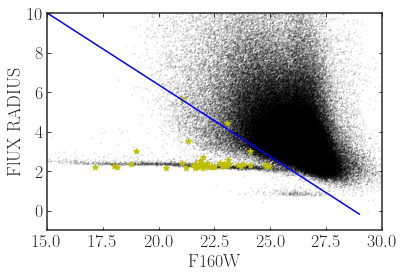

In [281]:
fig, ax=plt.subplots()
plt.scatter(hst3d_phot['Faper160_mag'],  hst3d_phot['flux_radius'], s=1., alpha=0.1, c='k', marker='+')
plt.scatter( hucds['F160W'],  hucds['flux_radius'], c='y', marker='*')

line_cut=np.poly1d(np.polyfit([ 15.0, 26.0], [10.0, 2.0], 1))

plt.plot(np.arange(15, 30.0),line_cut(np.arange(15.0, 30.0)), c='b')
plt.ylim([-1, 10])
plt.xlim([15, 30])



plt.ylabel('FlUX RADIUS')
plt.xlabel('F160W')

In [282]:
bools0= np.logical_and(merged.class_star !=0, merged.grism_id.str.startswith('par')) 
bools1= np.logical_and((~merged.grism_id.str.startswith('par')), (merged.flux_radius_x <  line_cut(merged.F160)))
bools2= merged.flux_radius_x < 1.5
merged['mstar_flag']= np.logical_or.reduce([bools0, bools1, bools2]).astype(int)

In [283]:
merged['flux_radius']=merged['flux_radius_x']
merg=merged.drop(['flux_radius_x', 'flux_radius_y'], axis=1)

In [284]:
#merg.to_hdf(wisps.LIBRARIES+'/master_dataset.h5', key='new')

In [285]:
#merged.mstar_flag

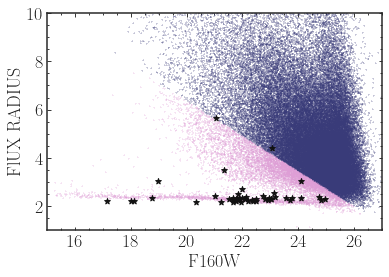

In [286]:
fig, ax=plt.subplots()
plt.scatter(merged['F160'],  merged['flux_radius'], s=1., alpha=0.3,
            c=merged.mstar_flag, marker='+', cmap='tab20b')
plt.scatter( hucds['F160W'],  hucds['flux_radius'], c='#111111', marker='*')

#line_cut=np.poly1d(np.polyfit([ 15.0, 26.0], [10.0, 2.0], 1))

#plt.plot(np.arange(15, 30.0),line_cut(np.arange(15.0, 30.0)), c='b')
plt.ylim([1, 10])
plt.xlim([15, 27])


plt.ylabel('FlUX RADIUS')
plt.xlabel('F160W')
plt.minorticks_on()
plt.savefig(wisps.OUTPUT_FIGURES+ '/point_sources_cut.pdf', dpi=50000, rasterized=True)

In [287]:
line_cut

poly1d([-0.72727273, 20.90909091])

In [288]:
#jhkl

In [289]:
stars=(merged[merged.mstar_flag >0]).reset_index(drop=True)
stars=stars[stars.snr1>=3.0]
cutphot=merged[((merged.snr1>=3.0))]
wispsph=alld[alld.grism_id.str.startswith('par')]
hst3d=alld[~ alld.grism_id.str.startswith('par')]

starswisp=stars[stars.grism_id.str.startswith('par')]
starshst3d=stars[(~ stars.grism_id.str.startswith('par'))]


In [290]:
#https://rmflight.github.io/post/finding-modes-using-kernel-density-estimates/

In [291]:
mag_limits={'wisps':{'F110W':[22.5, 18.0], 'F140W':[22., 16.0], 'F160W':[22.0, 16.0] }, 
            'hst3d':{'F140W':[23., 16.0], 'F160W':[23., 16.0] }}

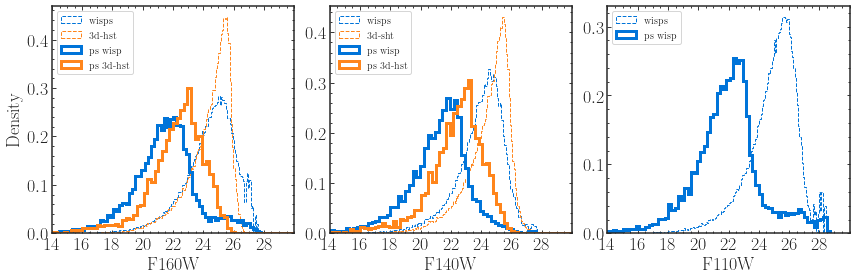

In [292]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
##top
h=ax[0].hist(wispsph.F160.dropna().values, label='wisps', bins='auto', color='#0074D9', density=True, histtype='step', linestyle='--')
h=ax[2].hist(wispsph.F110.dropna().values,  label='wisps', bins='auto', color='#0074D9', density=True, histtype='step', linestyle='--')
h=ax[1].hist(wispsph.F140.replace(np.inf, np.nan).dropna().values,   label='wisps', bins='auto', color='#0074D9', density=True, histtype='step' , linestyle='--')
#h=cutphot.F140.replace(np.inf, np.nan).dropna().plot(kind='hist', ax=ax[0][2], bins='auto',label='F140', color='#7FDBFF', density=True)

h=ax[0].hist(hst3d.F160.dropna().values,  label='3d-hst', bins='auto', color='#FF851B', density=True, histtype='step', linestyle='--')
#h=ax[2].hist(hst3d.F110.dropna().values,  label='3d-hst', bins='auto', color='#2ECC40', density=True, histtype='step',  linestyle='--')
h=ax[1].hist(hst3d.F140.replace(np.inf, np.nan).dropna().values,  label='3d-sht', bins='auto', color='#FF851B', density=True, histtype='step',  linestyle='--')

h=ax[0].hist(starswisp.F160.dropna().values,  label='ps wisp', bins='auto', color='#0074D9', density=True, linewidth=3, histtype='step')
h=ax[2].hist(starswisp.F110.dropna().values,   label='ps wisp', bins='auto', color='#0074D9', density=True, linewidth=3,histtype='step')
h=ax[1].hist(starswisp.F140.replace(np.inf, np.nan).dropna().values,   label='ps wisp', bins='auto',  color='#0074D9', linewidth=3,density=True, histtype='step')

h=ax[0].hist(starshst3d.F160.dropna().values,  label='ps 3d-hst', bins='auto', color='#FF851B', linewidth=3,density=True, histtype='step')
#h=ax[2].hist(starshst3d.F110.dropna().values,   label='ps 3d-hst', bins='auto', color='#111111', density=True, histtype='step')
h=ax[1].hist(starshst3d.F140.replace(np.inf, np.nan).dropna().values,   label='ps 3d-hst', bins='auto', linewidth=3, color='#FF851B', density=True, histtype='step')


#bayesian blocks
#H2 = ax[0][0].hist(cutphot.F160.replace(np.inf, np.nan).dropna(), bins=edgesf160, color='#111111',  density=True, lw =2, histtype='step')
#H2 = ax[0][1].hist(cutphot.F110.replace(np.inf, np.nan).dropna(), bins=edges110, color='#111111',  density=True, lw =2, histtype='step')
#H2 =ax[0][2].hist(cutphot.F140.replace(np.inf, np.nan).dropna(), bins=edges140, color='#111111',  density=True, lw =2, histtype='step')

#ax[0].axvline(mag_limits['wisps']['F140W'][0], color='#B10DC9', linestyle='-')
#ax[0].axvline(mag_limits['hst3d']['F140W'][0], color='#111111', linestyle='-')

#ax[2].axvline(mag_limits['wisps']['F110W'][0], color='#B10DC9', linestyle='-')
#ax[0][1].axvline(23,  color='#111111')


#ax[1].axvline(mag_limits['wisps']['F160W'][0],color='#B10DC9', linestyle='-')
#ax[1].axvline(mag_limits['hst3d']['F160W'][0], color='#111111', linestyle='-')





#ax[1][0].scatter( cutphot.F160, cutphot.exposure, marker=',', alpha=0.1, s=50)
#sns.kdeplot( cutphot.F160, cutphot.exposure, ax=ax[1][0])
#df=cutphot[['F160', 'exposure']].replace(np.inf, np.nan).dropna()
#ax[1][0].hist2d(df.F160.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

#df=cutphot[['F110', 'exposure']].replace(np.inf, np.nan).dropna()
#ax[1][2].hist2d(df.F110.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

#df=cutphot[['F140', 'exposure']].replace(np.inf, np.nan).dropna()
#ax[1][1].hist2d(df.F140.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

#sns.kdeplot( df.F160, df.exposure, ax=ax[1][0], shade=True)
#ax[1][1].scatter( cutphot.F110, cutphot.exposure, marker=',', alpha=0.1, s=50)
#ax[1][2].scatter( cutphot.F140, cutphot.exposure, marker=',', alpha=0.1, s=50)



ax[0].set_xlabel('F160W', fontsize=18)
ax[2].set_xlabel('F110W', fontsize=18)
ax[1].set_xlabel('F140W', fontsize=18)

#ax[1][0].set_ylabel('Exposure (s)', fontsize=18)
ax[0].set_ylabel('Density', fontsize=18)
#ax[1][2].set_ylabel('Exposure (s)', fontsize=18)

for a in ax:
    a.set_xticks(np.arange(14, 30, 2.0))
    a.set_xlim([14, 30])
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    a.xaxis.set_minor_locator
    #a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    #ml = MultipleLocator(.5)
    #a.xaxis.set_minor_locator(ml)
    a.minorticks_on()


#ax[0][0].set_ylim([0., 0.35])
#ax[0][1].set_ylim([0., 0.30])
#ax[0][2].set_ylim([0., 0.35])


ax[0].legend(loc='upper left', fontsize=10)
ax[1].legend(loc='upper left', fontsize=10)
ax[2].legend(loc='upper left', fontsize=10)
    
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limits_all.pdf', bbox_inches='tight')


In [293]:
ucds=pd.read_pickle('~/research/wisps/libraries/real_ucds.pkl')
ucds['class_star']=alld[alld.grism_id.str.lower().isin(ucds.grism_id.str.lower().values)].class_star.values

In [294]:
wucds=ucds[ucds.grism_id.str.lower().str.startswith('par')]
hucds=ucds[~ucds.grism_id.str.lower().str.startswith('par')]

(0.2, 1.5)

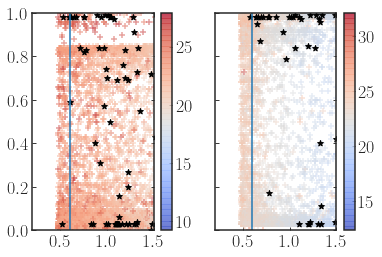

In [295]:
fig, (ax, ax1)=plt.subplots(ncols=2, sharex=True, sharey=True)
cx=ax.scatter(starswisp.snr1.apply(np.log10), starswisp.class_star,
            alpha=.5, marker='+',  c= starswisp.F160, cmap='coolwarm')
        
ax.scatter(wucds.snr1.apply(np.log10), wucds.class_star, marker='*', c='k')
plt.colorbar(cx, ax=ax)
#sns.scatterplot(starswisp.snr1.apply(np.log10), starswisp.snr1.apply(np.log10, s=5, color=".15", ax=ax)
#sns.histplot(x=cutdf.appF140, y=cutdf.snr.apply(np.log10), bins=50, pthresh=.1, cmap="mako")
#sns.kdeplot(starswisp.snr1.apply(np.log10), cutdf.snr.apply(np.log10), levels=5, color="w", linewidths=1)

c=ax1.scatter(starshst3d.snr1.apply(np.log10), starshst3d.class_star, 
            alpha=.5, marker='+', c=starshst3d.F160, cmap='coolwarm')
ax1.scatter(hucds.snr1.apply(np.log10), hucds.class_star, marker='*', c='k')
plt.colorbar(c)
ax.axvline(np.log10(4))
ax1.axvline(np.log10(4))

plt.ylim([0.0, 1.])
#plt.xlabel('')
plt.xlim([0.2, 1.5])

In [296]:
from astropy.io import fits
from astropy.table import Table

In [297]:
#scal=fits.open('https://urldefense.com/v3/__http://homepages.spa.umn.edu/*mscarlat/WISPPhotometricCatalog_v1.2.fits__;fg!!Mih3wA!V4jOw3ITlkzp1jvdGyu3fXDBgLCi8r-HtAKdSNKE66P5ojZq6a8aHNcZOde7Y84$')

In [298]:
#def grism_id(row): return 'par'+ str(int(row.PAR))+'-'+ str(int(row.OBJ)).zfill(5)
#tbl=Table(scal[1].data)
#tbl_df=(tbl['RA', 'DEC', 'PAR','OBJ', 'MAG_AUTO_F140W']).to_pandas()
#tbl_df['grism_id']=tbl_df.apply(grism_id, axis=1)
#merged=tbl_df.merge(fphot, on='grism_id')
#merged.columns
#plt.plot(merged.F140, merged.MAG_AUTO_F140W)

In [299]:
#tbl.columns

In [300]:
#sean_catalog= pd.read_csv(wisps.OUTPUT_FILES+'/wisps_point_sources.csv')

In [301]:

#import glob
#fileo=glob.glob(wisps.REMOTE_FOLDER+'/wisps/archive.stsci.edu/missions/hlsp/wisp/v6.2/'\
#+'par'+str(32)+'/*'+str('f140')+'*_cat.txt')[0]

In [302]:
#!open '/volumes/burgasserlab/Surveys///wisps/archive.stsci.edu/missions/hlsp/wisp/v6.2/par32/hlsp_wisp_hst_wfc3_par32_f140w_v6.2_cat.txt'

In [303]:
#from astropy.io import ascii
#ascii.read(fileo).to_pandas()

In [304]:
#plt.scatter(sean_catalog.half_light_rad, sean_catalog.mag, marker='+')

In [305]:
#s=ucds.spectra[ucds.class_star ==0 ].values[0]

In [306]:
#plt.plot(s.wave, s.flux)
#plt.xlim([1.1,1.7])
#plt.ylim([0.0, 1.])

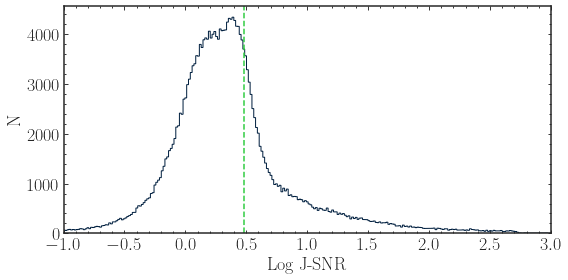

In [307]:
fig, ax1=plt.subplots(figsize=(8, 4), ncols=1, sharey=False)
#h=ax.hist(phot.f_test, bins='auto', color='#001f3f', density=False, histtype='step')

#ax.axvline(.4, color='#2ECC40', linestyle='--')
#ax.set_xlabel('F(x)', fontsize=18)
#ax.set_ylabel('N', fontsize=18)
#ax.minorticks_on()


h=ax1.hist(alld.snr1.apply(np.log10), bins='auto', 
           color='#001f3f', density=False, histtype='step')

ax1.axvline(np.log10(3.), color='#2ECC40', linestyle='--')
ax1.set_xlabel('Log J-SNR', fontsize=18)
ax1.set_ylabel('N', fontsize=18)
ax1.set_xlim([-1., 3.])

ax1.minorticks_on()
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/f_test_snr_distr.pdf')

In [308]:
#MAKE MAGNITUDE LIMIT POLYNOMIALS HERE
#jk

In [309]:
def get_max_value(values):
    values=wisps.drop_nan(values)
    if len(values)<1:
        return np.nan
    if np.equal.reduce(values):
        return np.nanmean(values)
    if len(values)>=1:
        kernel = wisps.kernel_density(values)
        height = kernel.pdf(values)
        mode_value = values[np.argmax(height)]
        return float(mode_value)
    
def get_polynomials(survey):
    exposure_times=[]
    mags=[]
    df=None
    
    if survey=='wisps': df= wisps.Annotator.reformat_table(starswisp)
    if survey=='hst3d': 
        df= wisps.Annotator.reformat_table(starshst3d)
    
    for g in df.groupby('pointing'):
        if len(g[1]) < 60:
            pass
        else:
            exposure_times.append(np.nanmedian(g[1].expt_f140w.values))
            mags.append([get_max_value(g[1].F110.values), 
                         get_max_value(g[1].F140.values), 
                         get_max_value(g[1].F160.values)])
            
    mags=np.vstack(mags)
    if survey=='hst3d': 
        p0=None
    else:
        bools0=np.logical_or.reduce([np.isnan(mags[:, 0]), mags[:,0] <15, mags[:,0] >25])
        _, p0=wisps.fit_with_nsigma_clipping(np.log10(exposure_times)[~bools0], 
                                             mags[:, 0][~bools0], (mags[:, 0]/100)[~bools0], sigma=5, n=1)
        
    bools1=np.logical_or.reduce([np.isnan(mags[:, 1]), mags[:,1] <15, mags[:,1] >25])
    bools2=np.logical_or.reduce([np.isnan(mags[:, 2]), mags[:,2] <15, mags[:,2] >25])
    _, p1=wisps.fit_with_nsigma_clipping(np.log10(exposure_times)[~bools1],
                                         mags[:, 1][~bools1], (mags[:, 1]/10)[~bools1], sigma=5, n=1)
    _, p2=wisps.fit_with_nsigma_clipping(np.log10(exposure_times)[~bools2], 
                                         mags[:, 2][~bools2], (mags[:, 2]/10)[~bools2],   sigma=5, n=1)
    
    return {survey: {"F110":(p0, np.nanstd(mags[:,0])), 
                     "F140": (p1, np.nanstd(mags[:,1])),
                     "F160":(p2, np.nanstd(mags[:,2]))}}, [mags,  exposure_times]


In [310]:
wisppol, mags0= get_polynomials('wisps')
hst3dpol, mags1= get_polynomials('hst3d')

In [311]:
expgrid=np.linspace(2, 4.2, 100)

In [312]:
#mags0[0]

(19.0, 25.0)

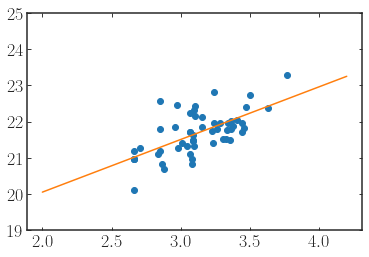

In [313]:
fig, ax=plt.subplots()
plt.plot(np.log10(mags0[1]), mags0[0][:,2], 'o')
plt.plot(expgrid, (wisppol['wisps']['F160'][0])(expgrid))
plt.ylim([19, 25])

In [38]:
#fit magnitude uncertainty as a functio
stars= (merg[merg.mstar_flag !=0]).reset_index(drop=True)
mask2=np.logical_or.reduce([np.isnan(stars.F140.values), np.isnan(stars.F140_er.values), 
                           np.abs(stars.F140_er.values)>=2 , stars.F140<15,  stars.F140>30 ])

mask3=np.logical_or.reduce([np.isnan(stars.F160.values), np.isnan(stars.F160_er.values), 
                           np.abs(stars.F160_er.values)>2 , stars.F160<15,  stars.F160>30  ])

mask1=np.logical_or.reduce([np.isnan(stars.F110.values), np.isnan(stars.F110_er.values), 
                           np.abs(stars.F110_er.values)>2 , stars.F110<15,  stars.F110>30  ])

mdata1=stars.F110.values[~mask1]
muncdata1= stars.F110_er.values[~mask1]
tdata1=stars.expt_f140w.values[~mask1]
#snrdata1=stars.exposure_time.values[~mask1]/np.nanmedian(stars.exposure_time.values[~mask1])

mdata2=stars.F140.values[~mask2]
muncdata2= stars.F140_er.values[~mask2]
tdata2=stars.expt_f140w.values[~mask2]

mdata3=stars.F160.values[~mask3]
muncdata3= stars.F160_er.values[~mask3]
tdata3=stars.expt_f140w.values[~mask3]

In [39]:
#bjkl

In [40]:

from scipy.optimize import curve_fit

In [41]:
import numpy as np
from scipy.optimize import minimize

In [346]:
def mag_exptime(params, t, m):
    a, b= params
    pred= a+b*np.log(t/np.nanmedian(t))
    return np.nansum((pred-m)**2)

@np.vectorize
def check_less(m, mc):
    return m<mc

def mag_unc_chisq(params, m, magunc, mnorm):
    m0, s0, c= params
    unc= np.zeros(len(m))
    mask=check_less(m, m0)
    unc[mask]=s0
    #mask=np.zeros(len(m)).astype(bool)
    #unc[~mask]=s0*(np.exp(c*m[~mask]))
    unc[~mask]= s0*((m[~mask]/mnorm)**c)
    return (magunc-unc)**2/len(m)

def simpler_function(params, mag, magunc):
    m0, s0, c= params
    #fit and compute chi-square for mag-fit
    #magfit= a+b*np.log(tx/np.nanmedian(tx))
    #mag_chi=(mag-magfit)**2/len(mag)
    #fit and compute chi-square for mag unc
    unc_chi= mag_unc_chisq([m0, s0, c], mag, magunc, np.nanmedian(mag))
    ##minimize the total chi-square
    return np.nansum(unc_chi)
    
    
def simpler_fit(m, munc,  guess):
    ##initial guess 
    res = minimize(simpler_function, guess, 
                   args=(m, munc), 
                   method='nelder-mead')
    return res.x



def mag_unc_exptime_relation( mag, params):
    m0, s0, c= params
    #m= a+ b*np.log(t/np.nanmedian(t))
    mnorm= np.nanmedian(mag)
    unc= np.zeros(len(mag))
    mask=check_less(mag, m0)
    unc[mask]=s0
    #mask=np.zeros(len(mag)).astype(bool)
    #unc[~mask]=s0*(np.exp(mag[~mask]*c))
    unc[~mask]= s0*((mag[~mask]/mnorm)**c)
    return unc

def fit_snr_exptime(params, ts, mag):
    d, e, f=params
    return  d*mag+e*np.log(ts/np.nanmedian(ts))+f


In [206]:

def k_clip_fit(m, munc,parms,  sigma = 5):
    '''Fit k-sigma clip until convergence
    hard-coded, returns mask array
    '''
    not_clipped = np.ones_like(m).astype(bool)
    n_remove = 1
    while n_remove > 0:
        parms=  simpler_fit(m, munc, parms)
        best_fit =mag_unc_exptime_relation( m,  parms)
        #compute residuals
        norm_res = np.abs(munc - best_fit)/np.nanstd(munc)
        remove = np.logical_and(norm_res >= sigma, not_clipped == 1)
        n_remove = np.nansum(remove)
        not_clipped[remove] = 0   
    return  not_clipped, parms


In [337]:
mag_unc_chisq([17, 2, 3.0],mdata2, muncdata2, 20)

array([0.00069496, 0.00053556, 0.00045813, ..., 0.00020831, 0.00041578,
       0.00018324])

In [354]:
#start by averaging over exposure time
guess=[17, 2, 3.0]
res2=simpler_fit(mdata2, muncdata2, guess)
res3=k_clip_fit(mdata2, muncdata2,guess,  sigma = 3)

In [361]:
grps=[x for x in stars.groupby('expt_f140w')]

In [423]:
def combine_mag_groups():
    #combine small exposure times and large exposure times
    combined=[]
    #idxs=np.array([i for i, _ in enumerate(grps)])
    rs=[100, 500, 1000, 1500, 2000, 3000, 6900, 7000]
    for idx,_ in enumerate(rs):
        left=rs[idx]
        if idx==(len(rs)-1):
            pass
        else:
            right=rs[idx+1]
            combined.append(pd.concat([x[1] for x in grps if np.logical_and(x[0]>=left, x[0]<right)]))
    return combined
        
        
        

In [424]:
cbmined= combine_mag_groups()

ValueError: No objects to concatenate

In [425]:
allfits={}
for g in np.vstack(grps)[:,1]:
    fits={}
    for f in ['F110', 'F140', 'F160']:
        mags=g[f].values
        uncs= g[f+'_er'].values
        mask=np.logical_or.reduce([np.isnan(mags), np.isnan(uncs), 
                               np.abs(uncs)>=0.6 , mags<17,  mags>28 ])
        if  (len(mags[~mask])) < 20:
            fits.update({f: []})
        else:
            guess=[17, 0.01, 3.0]
            res=simpler_fit(mags[~mask], uncs[~mask], guess)
            fits.update({f: res})
            #fig, ax=plt.subplots()
            #ax.scatter(mags[~mask], uncs[~mask])
    allfits.update({g['expt_'+f.lower()+'w'].median(): fits})
        

In [426]:
mgrid=np.linspace(10, 30, 1000)

In [ ]:
#stars.ex

Text(0.5, 12.558635706919361, 'F160W')

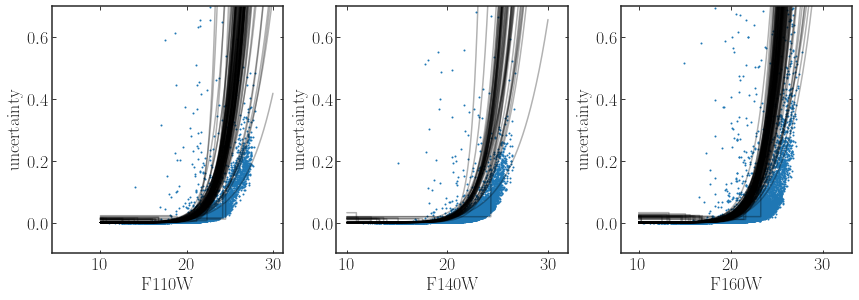

In [429]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))

c=ax[0].scatter(stars['F110'], stars['F110_er'], s=1)
c=ax[1].scatter(stars['F140'], stars['F140_er'], s=1)
c=ax[2].scatter(stars['F160'], stars['F160_er'], s=1)
plt.tight_layout()

for k in allfits.keys():
    fit=allfits[k]
    for a, mk in zip(ax, ['F110', 'F140', 'F160']):
        res=  allfits[k][mk]
        if len(res)>1:
            a.plot(mgrid,  mag_unc_exptime_relation( mgrid, res), 
                   c='k', alpha=0.3)
for a in ax:
    a.set_ylim([-0.1, 0.7])
    a.set_ylabel('uncertainty')
    
ax[0].set_xlabel('F110W')
ax[1].set_xlabel('F140W')
ax[2].set_xlabel('F160W')



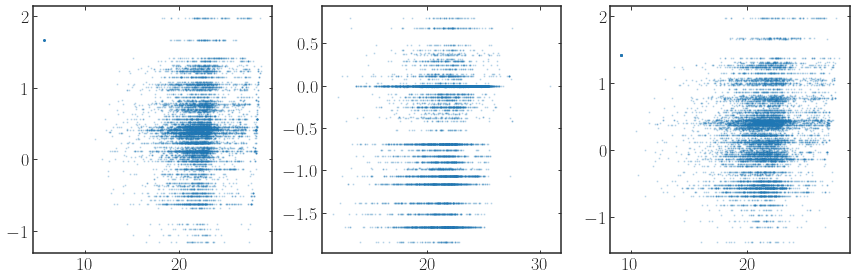

In [430]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))

c=ax[0].scatter(stars['F110'], np.log(stars.expt_f110w/stars.expt_f110w.median()), s=1, alpha=0.2)
c=ax[1].scatter(stars['F140'], np.log(stars.expt_f140w/stars.expt_f140w.median()), s=1, alpha=0.2)
c=ax[2].scatter(stars['F160'],np.log(stars.expt_f160w/stars.expt_f160w.median()), s=1, alpha=0.2)

plt.tight_layout()

In [433]:
from scipy.interpolate import griddata

In [ ]:
jhk

In [ ]:
import emcee

def lnlike(theta, mag, magunc, tx):
    return -0.5*simpler_function(theta, mag, magunc, tx)

def lnprior(theta):
    m0, b, s0, c = theta
    if 15.0 < m0 < 30 and 0.0 < b < 10.0 and 0 < s0 < 1.0  and 0<c<20:
        return 0.0
    return -np.inf

def lnprob(theta, mag, magunc, tx):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, mag, magunc, tx)

def run_mcmc_ugh(res, data):
    ndim, nwalkers = 4, 100
    pos = [res + res*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                    args=(data[0], data[1],data[2]))
    outp=sampler.run_mcmc(pos, 1000,  progress=True)
    samples = sampler.chain.reshape((-1, ndim))
    return np.nanmedian(samples, axis=0)
#res1mc=run_mcmc_ugh(res1, (mdata1, muncdata1, tdata1))
#res2mc=run_mcmc_ugh(res2, (mdata2, muncdata2, tdata2))
#res3mc=run_mcmc_ugh(res3, (mdata3, muncdata3, tdata3))

In [ ]:
#!pip install emcee

In [ ]:

def fit_snr_exptime(params, snr, ts, mag):
    d, e, f=params
    snrfits= d*mag+e*np.log(ts/np.nanmedian(ts))+f
    return np.nansum((snrfits-snr)**2)/len(snr)

In [ ]:
d0, e0, f0=2.0, 2.0, 1.0
ts=stars.exposure_time.values
snrs=stars.snr1.apply(np.log10).values
mags= stars.F140.values
mask= np.logical_and.reduce([snrs >=-4, snrs<5, mags>15, mags<30])
fit_snr_exptime([d0, e0, f0], snrs[mask], ts[mask], mags[mask])

In [ ]:
d0, e0, f0=2.0, 2.0, 1.0
res = minimize(fit_snr_exptime, [d0, e0, f0], 
               args=(snrs[mask], ts[mask], mags[mask]),
               method='nelder-mead')
print ('-----best fits -------')
print (res)

In [ ]:
d, e, f= res.x


plt.plot(mags[mask], snrs[mask], '.', alpha=0.5)
plt.plot(mags, d*mags+e*np.log(ts/np.nanmedian(ts))+f, '.',
            c='r')
plt.xlabel('MAG')
plt.ylabel('LOG J-SNR')

In [ ]:
pol = {**wisppol, **hst3dpol, 'ncutoff':60}
pol['mag_unc_exp']= {'F110': [ res1mc[0], res1mc[1], res1mc[2], res1mc[3]],
                    'F140':  [res2mc[0], res1mc[1], res2mc[2], res2mc[3]],
                     'F160': [ res3mc[0], res1mc[1], res3mc[2], res3mc[3]]}
pol['ncutoff']=60
pol['snr_exp']= res.x

In [ ]:
res

In [ ]:
import pickle
output_file=wisps.OUTPUT_FILES+'/magnitude_cutoff.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(pol,file)